# Traitement automatique des données Poids (Withings HealthMate),
# Food (MyFitnessPal), et Exercices (Polar)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

from zipfile import ZipFile

import datetime
import json
import re
import shutil

from tqdm import tqdm

import seaborn as sns

import ipywidgets
import os

In [2]:
# ici, aller chercher dans Download
# les fichiers commençant par data-user... , data_BEN..., etc.
# repérer les plus récents (= derniers downloads)
# et copier ces plus récents dans imports avec le nom qui va bien

# voir :
# os.listdir : liste fichiers
# os.stat_result : donne infos sur fichier x (dont date dernière modif)
# shutil.copy : copie fichier endroit X à l'endroit Y

downloads_rep = "/home/benjamin/Downloads/"
liste_downloaded_files = os.listdir(downloads_rep)

if len(liste_downloaded_files) == 0:
    raise NameError(f"Aucun fichier n'est présent dans {downloads_rep}")

In [3]:
# recherche fichiers POIDS : format data_BEN_xxxxxx.zip

# Source : Withings https://healthmate.withings.com/

# Account > User > Parameters > Download ==> data_BEN_xxxxx.zip ==> contient weight.csv

pattern_poids = "^data_BEN_[\d]+[.]zip"
eng = re.compile(pattern_poids)
liste_zip_poids = []
liste_mtime_zips = []

for f in liste_downloaded_files:
    m = eng.search(f)
    if m:  # si on trouve un data_BEN_dddd.zip, on note le nom du fichier et le temps de modif
        filename = m.group(0)
        liste_zip_poids.append(filename)
        mtime = os.stat(downloads_rep + f).st_mtime
        liste_mtime_zips.append(mtime)
        
if len(liste_zip_poids) == 0:
    raise NameError(f'Aucun fichier de type data_BEN_xxxx.zip contenant \
        les données poids ne figure dans le répertoire {downloads_rep}')
    
# print(liste_zip_poids)

idx = np.argmax(liste_mtime_zips)
filename_poids = liste_zip_poids[idx]

print(f"Le fichier poids le plus récent est : {filename_poids}, parmi :\n")
for f in liste_zip_poids:
    print(f"{f}")

Le fichier poids le plus récent est : data_BEN_1695179927.zip, parmi :

data_BEN_1694923224.zip
data_BEN_1694493968.zip
data_BEN_1694665218.zip
data_BEN_1694761970.zip
data_BEN_1695096393.zip
data_BEN_1695011628.zip
data_BEN_1694836398.zip
data_BEN_1695179927.zip
data_BEN_1694575743.zip


In [4]:
# recherche fichiers FOOD : format File-Export-YYYY-MM-DD-to-YYYY-MM-DD.zip

# https://www.myfitnesspal.com/reports

# www.myfitnesspal.com ==> reports > export data ==> File-Export-date1-to-date2.zip

pattern_food = "^File-Export-[\d]{4}-[\d]{2}-[\d]{2}-to-[\d]{4}-[\d]{2}-[\d]{2}.*[.]zip"
eng = re.compile(pattern_food)
liste_zip_food = []
liste_mtime_zips = []

for f in liste_downloaded_files:
    m = eng.search(f)
    if m:  # si on trouve un File-Export-....zip, on note le nom du fichier et le temps de modif
        filename = m.group(0)
        liste_zip_food.append(filename)
        mtime = os.stat(downloads_rep + f).st_mtime
        liste_mtime_zips.append(mtime)
        
if len(liste_zip_food) == 0:
    raise NameError(f'Aucun fichier de type File-Export-xxxx.zip contenant \
        les données food ne figure dans le répertoire {downloads_rep}')
    
# print(liste_zip_food)

idx = np.argmax(liste_mtime_zips)
filename_food = liste_zip_food[idx]

print(f"Le fichier food le plus récent est : {filename_food}, parmi \n")

for f in liste_zip_food:
    print(f"{f}")

Le fichier food le plus récent est : File-Export-2020-08-03-to-2023-09-20.zip, parmi 

File-Export-2020-08-03-to-2023-09-17.zip
File-Export-2020-08-03-to-2023-09-18.zip
File-Export-2020-08-03-to-2023-09-19.zip
File-Export-2020-08-03-to-2023-09-20.zip
File-Export-2020-08-03-to-2023-09-16.zip
File-Export-2020-08-03-to-2023-09-14.zip
File-Export-2020-08-03-to-2023-09-15.zip
File-Export-2020-08-03-to-2023-09-13.zip
File-Export-2020-08-03-to-2023-09-12.zip


In [5]:
# recherche fichiers EXO par POLAR : format polar-user-data-export.zip

# https://account.polar.com/#export ==> polar-user-data-export-xxxxx.zip

pattern_polar = "^polar-user-data-export_.+[.]zip"
eng = re.compile(pattern_polar)
liste_zip_polar = []
liste_mtime_zips = []

for f in liste_downloaded_files:
    m = eng.search(f)
    if m:  # si on trouve un polar-user-data-export_....zip, on note le nom du fichier et le temps de modif
        filename = m.group(0)
        liste_zip_polar.append(filename)
        mtime = os.stat(downloads_rep + f).st_mtime
        liste_mtime_zips.append(mtime)
        
if len(liste_zip_polar) == 0:
    raise NameError(f'Aucun fichier de type polar-user-data-export_xxxx.zip contenant \
        les données exercices de Polar ne figure dans le répertoire {downloads_rep}')
    
# print(liste_zip_polar)

idx = np.argmax(liste_mtime_zips)
filename_polar = liste_zip_polar[idx]

print(f"Le fichier exercices le plus récent est : {filename_polar}, parmi :\n")

for f in liste_zip_polar:
    print(f"{f}")

Le fichier exercices le plus récent est : polar-user-data-export_e39d4a68-2ed4-435a-82e3-5c757afbacba.zip, parmi :

polar-user-data-export_e39d4a68-2ed4-435a-82e3-5c757afbacba.zip
polar-user-data-export_9e0816c6-c7d2-44fb-8a31-67fbe41e4083.zip
polar-user-data-export_b6f9acd2-aa95-45b3-86ca-d1952ba19e1d.zip


In [6]:
# copie les trois fichiers sélectionnés dans le répertoire de travail

import_pathname = '/home/benjamin/Folders_Python/Weight_imports/'

src = [filename_food,
       filename_poids,
       filename_polar]

dst = ['food', 'poids', 'polar']

for s,d in zip(src, dst):
       shutil.copy(downloads_rep + s, import_pathname + d)
       
print(f"Utilise : {filename_food}, {filename_poids}, {filename_polar}")

Utilise : File-Export-2020-08-03-to-2023-09-20.zip, data_BEN_1695179927.zip, polar-user-data-export_e39d4a68-2ed4-435a-82e3-5c757afbacba.zip


In [7]:
# Récupère données POIDS

withings_filename = import_pathname + 'poids'  # fichier zip le plus récent de HealthMate Withings

with ZipFile(withings_filename, 'r') as weight_zip:
    weight_csv = weight_zip.extract('weight.csv', path=import_pathname)

# extrait la dataframe poids ----------------

colnames = ['Date', 'Poids (kg)', 'Gras (kg)', 'Masse osseuse (kg)', 'Masse musculaire (kg)', 'Hydratation (kg)']

df_weight = pd.read_csv(weight_csv, usecols=colnames)

os.remove(weight_csv)

df_weight.rename(columns = {'Poids (kg)' : 'Masse_Totale' , 
                            'Gras (kg)' : 'Masse_Grasse',
                            'Masse osseuse (kg)' : 'Masse_Osseuse',
                            'Masse musculaire (kg)' : 'Masse_Musculaire',
                            'Hydratation (kg)' : 'Masse_Hydrique'
                            }, 
                 inplace=True)

# transforme le champ str de Date en datetime object

date_format = '%Y-%m-%d %H:%M:%S'

df_weight['Date'] = df_weight['Date'].apply(lambda x : datetime.datetime.strptime(x, date_format).date())
df_weight = df_weight.groupby('Date').mean()

start_date = datetime.date(2020, 8, 1)  # on prend les data depuis le 1er Août 2020

df_weight = df_weight[df_weight.index >= start_date]

subset = ['Masse_Totale', 'Masse_Grasse']
df_weight.dropna(subset = subset, inplace=True)

# df_weight['Masse_Maigre'] = df_weight['Masse_Totale'] - df_weight['Masse_Grasse']
df_weight['MG%'] = df_weight['Masse_Grasse'] / df_weight['Masse_Totale']
df_weight['BMR'] = 370 + 21.6 * (df_weight['Masse_Totale'] - df_weight['Masse_Grasse'])

df_weight.sort_index(inplace=True)

In [8]:
# forward propagate actual values into NaN
df_weight.fillna(method="ffill", inplace=True)

In [9]:
df_weight.tail(15)

,Masse_Totale,Masse_Grasse,Masse_Osseuse,Masse_Musculaire,Masse_Hydrique,MG%,BMR
Date,,,,,,,
2023-09-06,72.970000,11.182500,3.101250,58.670000,42.086250,0.153248,1704.610000
2023-09-07,71.265000,10.955000,3.022500,57.270000,40.672500,0.153722,1672.696000
2023-09-08,71.157500,11.241250,3.000000,56.902500,40.203750,0.157977,1664.191000
2023-09-09,73.856000,11.454000,3.134000,59.250000,42.600000,0.155086,1717.883200
2023-09-10,71.177000,10.929000,3.019000,57.211000,40.620000,0.153547,1671.356800
2023-09-11,71.202000,11.396000,2.990000,56.798000,40.060000,0.160052,1661.809600
2023-09-12,70.967778,11.065556,3.000000,56.888889,40.235556,0.155924,1663.888000
2023-09-13,71.294286,11.110000,3.012857,57.158571,40.508571,0.155833,1669.980571
2023-09-14,70.705556,11.083333,2.982222,56.621111,39.953333,0.156753,1657.840000


In [10]:
df_weight.rolling(window=7).mean().tail(15)

,Masse_Totale,Masse_Grasse,Masse_Osseuse,Masse_Musculaire,Masse_Hydrique,MG%,BMR
Date,,,,,,,
2023-09-06,71.453333,10.784421,3.043744,57.609588,41.105633,0.150928,1680.448502
2023-09-07,71.443333,10.800314,3.042316,57.584766,41.074026,0.151173,1679.889216
2023-09-08,71.515425,10.805595,3.046193,57.648185,41.138235,0.151086,1681.332339
2023-09-09,71.839139,10.899023,3.058193,57.865940,41.336602,0.151690,1686.306510
2023-09-10,71.809119,10.912758,3.055806,57.824246,41.288643,0.151947,1685.361400
2023-09-11,71.831786,11.037107,3.048821,57.729357,41.150071,0.153646,1683.165057
2023-09-12,71.799325,11.174758,3.038107,57.570056,40.925437,0.155651,1679.490657
2023-09-13,71.559938,11.164401,3.025480,57.354137,40.700054,0.156020,1674.543596
2023-09-14,71.480017,11.182734,3.019726,57.261439,40.597316,0.156453,1672.421310


In [11]:
# Récupère données FOOD

mfp_filename = import_pathname + "food" # données de My Fitness Pal

# Extrait les archives
    
with ZipFile(mfp_filename, 'r') as food_zip:
    output_dir = food_zip.namelist()
    target = 'Nutrition-Summary'
    for l in output_dir:
        if l[:len(target)] == target:
            food_csv = food_zip.extract(l, path=import_pathname)
            break
        
# extrait la dataframe food -------------------------------

colnames = ['Date', 'Meal', 'Calories', 'Fat (g)', 'Carbohydrates (g)', 'Protein (g)']

df_food = pd.read_csv(food_csv, usecols=colnames)
os.remove(food_csv)

df_food.rename(columns = {'Fat (g)' : 'Lipides' , 'Carbohydrates (g)' : 'Glucides', 'Protein (g)' : 'Proteines'}, inplace=True)

In [12]:
# df_food.tail(15)

In [13]:
# transforme le champ str de Date en datetime object

date_format = '%Y-%m-%d'

df_food['Date'] = df_food['Date'].apply(lambda x : datetime.datetime.strptime(x, date_format).date())
df_food = df_food.groupby('Date').sum(numeric_only=True)

start_date = datetime.date(2020, 8, 1)  # on prend les data depuis le 1er Août 2020

df_food = df_food[df_food.index >= start_date]
df_food.dropna(inplace=True)
df_food.sort_index(inplace=True)

In [14]:
df_food.tail(15)

,Calories,Lipides,Glucides,Proteines
Date,,,,
2023-09-05,2512.9,65.0,285.1,200.4
2023-09-06,1706.6,21.9,192.8,187.2
2023-09-07,1830.4,42.6,215.3,152.6
2023-09-08,2464.5,37.8,402.0,133.8
2023-09-09,1362.5,51.8,195.4,25.8
2023-09-10,1874.4,62.3,164.4,166.5
2023-09-11,1647.4,36.9,140.7,192.6
2023-09-12,1676.0,43.9,120.0,200.6
2023-09-13,1696.2,38.5,134.6,205.0


In [15]:
df_food.rolling(window=7).mean().tail(15)

,Calories,Lipides,Glucides,Proteines
Date,,,,
2023-09-05,1947.857143,45.114286,219.271429,161.028571
2023-09-06,1871.142857,44.071429,203.285714,164.328571
2023-09-07,1897.285714,43.071429,218.300000,160.928571
2023-09-08,1917.671429,41.985714,233.657143,153.671429
2023-09-09,1904.571429,45.542857,242.200000,133.128571
2023-09-10,1909.557143,44.842857,232.928571,146.171429
2023-09-11,1914.100000,45.471429,227.957143,151.271429
2023-09-12,1794.542857,42.457143,204.371429,151.300000
2023-09-13,1793.057143,44.828571,196.057143,153.842857


In [16]:
def extract_data_training(exo_dict):
    # utility fonction pour récupérer : date, durée, type exercice et calories dépensées
    
    # récupère date
    pattern = '2(\d){3,3}-(\d){2,2}-(\d){2,2}'  # on cherche une date du type 2xxx-yy-zz
    p = re.compile(pattern)
    m = p.search(exo_dict.get('startTime'))
    if m: 
        time_format = '%Y-%m-%d'
        exo_date = datetime.datetime.strptime( exo_dict.get('startTime')[:10], time_format ).date()
    
    # récupère durée
    pattern = '(\d)+[.]?(\d)*'  # on cherche une durée du type xxxx.yyyy
    p = re.compile(pattern)
    m = p.search(exo_dict.get('duration'))
    if m:
        exo_duration = float(m.group())
    
    # récupère type activité et calories dépensées
    d = exo_dict.get('exercises')[0]   
    exo_type = d.get('sport')
    if d.get('kiloCalories'):
        exo_cals = float(d.get('kiloCalories'))
    else:
        exo_cals = 0.0
    
    return exo_date, exo_duration, exo_type, exo_cals

In [17]:
# Récupère les données EXERCICE

polar_filename = import_pathname + "polar"  # données de Polar

with ZipFile(polar_filename, 'r') as polar_zip:
    output_dir = polar_zip.namelist()
    
    target = 'training-session'
    dict_all_exos = {}
    for i, enr_name in enumerate(tqdm(output_dir)): # on parcourt la liste des archives
        if enr_name[:len(target)] == target:  # si c'est un enregistrement d'une session de training, on traite
            enr_json = polar_zip.extract(enr_name, path=import_pathname)   # extraction du json
            with open(enr_json, 'r') as f:
                exo_dict = json.load(f)
                exo_date, exo_duration, exo_type, exo_cals = extract_data_training(exo_dict)
                if dict_all_exos.get(exo_date) == None:
                    dict_all_exos[exo_date] = [ exo_duration, exo_cals]
                else:
                    dict_all_exos[exo_date] = [ dict_all_exos[exo_date][0] + exo_duration, dict_all_exos[exo_date][1] + exo_cals ]
                # print(f'exercice {i+1} : date = {exo_date}, durée = {exo_duration}, type = {exo_type}, cals = {exo_cals}')
            os.remove(enr_json)
    
    df_exos = pd.DataFrame.from_dict(dict_all_exos, orient='index', columns=['exo_duree', 'exo_cals_bruts']).sort_index()

100%|██████████| 1618/1618 [01:02<00:00, 25.81it/s]


In [18]:
df_exos.tail(15)

,exo_duree,exo_cals_bruts
2023-08-30,1260.712,177.0
2023-08-31,3300.837,489.0
2023-09-01,1740.573,240.0
2023-09-02,1980.838,135.0
2023-09-03,1779.773,205.0
2023-09-04,1743.004,167.0
2023-09-06,3660.712,222.0
2023-09-07,3120.837,534.0
2023-09-08,3000.841,372.0
2023-09-09,1800.676,248.0


In [19]:
# Ajout à la main des exos depuis le xx Janvier inclus pour palier à la fréquence de rafraîchissement de l'extraction Polar

# récupère fichier brut .csv
exos_persos_filename = "/home/benjamin/Folders_Python/Weight_imports/Exos_Persos.csv"
df_exos_persos = pd.read_csv(exos_persos_filename)

# convertit la colonne Jour en datetime objects en colonne Date
pattern_date = '[\d]{2}/[\d]{2}/[\d]{2}'
p = re.compile(pattern_date)

day_format = "%d/%m/%y"

df_exos_persos['Date'] = df_exos_persos['Jour'].apply( lambda x : datetime.datetime.strptime(p.search(x).group(0), day_format).date() )

# drope la colonne Jour, somme tous les exercices par date
df_exos_persos.drop(columns=['Jour'], inplace=True)

df_exos_persos = df_exos_persos.groupby('Date').sum()

# met au bon format la duree de l'exercice (minutes => secondes)
df_exos_persos['exo_duree'] = df_exos_persos['Duree'] * 60
df_exos_persos.drop(columns=['Duree'], inplace=True)

In [20]:
df_exos_persos

,exo_cals_bruts,exo_duree
Date,,
2023-09-16,226,1740
2023-09-17,456,4860
2023-09-18,310,1980
2023-09-19,280,1860


In [21]:
# enfin, concatène avec le fichier issu de Polar
df_exos_total = pd.concat( [df_exos, df_exos_persos], axis=0 ).sort_index()

In [22]:
df_exos_total.tail(15)

,exo_duree,exo_cals_bruts
2023-09-03,1779.773,205.0
2023-09-04,1743.004,167.0
2023-09-06,3660.712,222.0
2023-09-07,3120.837,534.0
2023-09-08,3000.841,372.0
2023-09-09,1800.676,248.0
2023-09-10,4983.963,480.0
2023-09-12,2160.741,340.0
2023-09-13,3480.000,256.0
2023-09-14,1200.000,75.0


In [23]:
df_exos_total.rolling(window=7).mean().tail(15)

,exo_duree,exo_cals_bruts
2023-09-03,2440.670143,276.857143
2023-09-04,1935.280000,233.000000
2023-09-06,2209.492714,233.571429
2023-09-07,2475.224857,284.571429
2023-09-08,2432.368286,267.857143
2023-09-09,2440.954429,269.000000
2023-09-10,2869.972286,318.285714
2023-09-12,2924.396286,337.571429
2023-09-13,3172.538571,350.285714
2023-09-14,2821.008286,329.285714


In [24]:
df_all = pd.concat( [df_weight, df_food, df_exos_total], axis=1 ).sort_index()

# remplace les NaN dans les colonnes exercice par 0.0 : jour sans exercice
df_all['exo_duree'].fillna(0.0, inplace=True)
df_all['exo_cals_bruts'].fillna(0.0, inplace=True)

# drop les jours où il manque des données autres que les exercices
subset = ['Masse_Totale', 'Masse_Grasse', 'Calories']
df_all.dropna(subset = subset, inplace=True)

In [25]:
def exo_cals_nets(bmr, exo_duree, exo_cals_bruts):
    if exo_cals_bruts > 0:
        ecn = exo_cals_bruts - bmr / (24*60*60) * exo_duree
    else:
        ecn = 0.0
        
    return ecn

df_all['exo_cals_nets'] = np.where(df_all['exo_cals_bruts'] > 0, df_all['exo_cals_bruts'] - df_all['BMR'] / (24*60*60) * df_all['exo_duree'], 0 )

In [26]:
df_all['Depense_cal_totale'] = df_all['BMR'] + df_all['exo_cals_nets']
df_all['cal_deficit'] = df_all['Calories'] - (df_all['BMR'] + df_all['exo_cals_nets'])

In [27]:
# df_all.head(20)
# df_all.describe(include='all')
# df_all.info()

In [28]:
df_all.tail(15)

,Masse_Totale,Masse_Grasse,Masse_Osseuse,Masse_Musculaire,Masse_Hydrique,MG%,BMR,Calories,Lipides,Glucides,Proteines,exo_duree,exo_cals_bruts,exo_cals_nets,Depense_cal_totale,cal_deficit
2023-09-05,71.195000,10.102000,3.075000,58.004000,41.808000,0.141892,1689.608800,2512.9,65.0,285.1,200.4,0.000,0.0,0.000000,1689.608800,823.291200
2023-09-06,72.970000,11.182500,3.101250,58.670000,42.086250,0.153248,1704.610000,1706.6,21.9,192.8,187.2,3660.712,222.0,149.776779,1854.386779,-147.786779
2023-09-07,71.265000,10.955000,3.022500,57.270000,40.672500,0.153722,1672.696000,1830.4,42.6,215.3,152.6,3120.837,534.0,473.580885,2146.276885,-315.876885
2023-09-08,71.157500,11.241250,3.000000,56.902500,40.203750,0.157977,1664.191000,2464.5,37.8,402.0,133.8,3000.841,372.0,314.199391,1978.390391,486.109609
2023-09-09,73.856000,11.454000,3.134000,59.250000,42.600000,0.155086,1717.883200,1362.5,51.8,195.4,25.8,1800.676,248.0,212.197326,1930.080526,-567.580526
2023-09-10,71.177000,10.929000,3.019000,57.211000,40.620000,0.153547,1671.356800,1874.4,62.3,164.4,166.5,4983.963,480.0,383.588189,2054.944989,-180.544989
2023-09-11,71.202000,11.396000,2.990000,56.798000,40.060000,0.160052,1661.809600,1647.4,36.9,140.7,192.6,0.000,0.0,0.000000,1661.809600,-14.409600
2023-09-12,70.967778,11.065556,3.000000,56.888889,40.235556,0.155924,1663.888000,1676.0,43.9,120.0,200.6,2160.741,340.0,298.388530,1962.276530,-286.276530
2023-09-13,71.294286,11.110000,3.012857,57.158571,40.508571,0.155833,1669.980571,1696.2,38.5,134.6,205.0,3480.000,256.0,188.736894,1858.717465,-162.517465
2023-09-14,70.705556,11.083333,2.982222,56.621111,39.953333,0.156753,1657.840000,1498.1,38.3,127.5,158.5,1200.000,75.0,51.974444,1709.814444,-211.714444


In [29]:
df_all.rolling(window=7).mean().tail(15)

,Masse_Totale,Masse_Grasse,Masse_Osseuse,Masse_Musculaire,Masse_Hydrique,MG%,BMR,Calories,Lipides,Glucides,Proteines,exo_duree,exo_cals_bruts,exo_cals_nets,Depense_cal_totale,cal_deficit
2023-09-05,71.219940,10.709243,3.035530,57.459409,40.971347,0.150376,1677.031073,1947.857143,45.114286,219.271429,161.028571,1686.533857,201.857143,169.159107,1846.190181,101.666962
2023-09-06,71.453333,10.784421,3.043744,57.609588,41.105633,0.150928,1680.448502,1871.142857,44.071429,203.285714,164.328571,2029.391000,208.285714,168.773488,1849.221990,21.920867
2023-09-07,71.443333,10.800314,3.042316,57.584766,41.074026,0.151173,1679.889216,1897.285714,43.071429,218.300000,160.928571,2003.676714,214.714286,175.721252,1855.610469,41.675246
2023-09-08,71.515425,10.805595,3.046193,57.648185,41.138235,0.151086,1681.332339,1917.671429,41.985714,233.657143,153.671429,2183.715000,233.571429,191.081521,1872.413860,45.257569
2023-09-09,71.839139,10.899023,3.058193,57.865940,41.336602,0.151690,1686.306510,1904.571429,45.542857,242.200000,133.128571,2157.977571,249.714286,207.622073,1893.928583,10.642845
2023-09-10,71.809119,10.912758,3.055806,57.824246,41.288643,0.151947,1685.361400,1909.557143,44.842857,232.928571,146.171429,2615.719000,289.000000,238.072519,1923.433919,-13.876776
2023-09-11,71.831786,11.037107,3.048821,57.729357,41.150071,0.153646,1683.165057,1914.100000,45.471429,227.957143,151.271429,2366.718429,265.142857,219.048939,1902.213996,11.886004
2023-09-12,71.799325,11.174758,3.038107,57.570056,40.925437,0.155651,1679.490657,1794.542857,42.457143,204.371429,151.300000,2675.395714,313.714286,261.675871,1941.166529,-146.623671
2023-09-13,71.559938,11.164401,3.025480,57.354137,40.700054,0.156020,1674.543596,1793.057143,44.828571,196.057143,153.842857,2649.579714,318.571429,267.241602,1941.785198,-148.728055
2023-09-14,71.480017,11.182734,3.019726,57.261439,40.597316,0.156453,1672.421310,1745.585714,44.214286,183.514286,154.685714,2375.174429,253.000000,207.012111,1879.433421,-133.847707


# Graphes

In [30]:
vars = ['Masse_Grasse', 'MG%', 'Calories', 'cal_deficit', 'Masse_Musculaire'] # 'Masse_Grasse', 'BMR', 'Masse_Totale', 'exo_cals_nets', 'Masse_Musculaire', 

dict_hlines = {
        'Calories' : [ (1600, 'green'), (1700, 'orange'), (1800, 'red') ],
        'cal_deficit' : [ (-500, 'green'), (-200, 'orange'), (200, 'red' ) ],
        'MG%' : [ (.14, 'green'), (.15, 'orange'), (.16,'red') ]
    }

In [31]:
def plot_general(longueur=15,
                 year=2023,
                 month=5,
                 day=1,
                #  vars = vars,
                #  dict_hlines = dict_hlines
):
    
    # vars = ['Masse_Totale', 'MG%', 'Calories', 'Depense_cal_totale', 'cal_deficit'] # 'Masse_Grasse', 'BMR',
    
    subset = ['Masse_Totale', 'Masse_Grasse'] # on permet des NaN en masse osseuse, etc en attendant d'avoir des data
    df_all2 = df_all.rolling(longueur).mean().dropna(subset = subset)
    start_date = datetime.date(year=year, month=month, day=day)

    df_all2 = df_all2[df_all2.index >= start_date]

    for v in vars:
        fig, ax = plt.subplots(figsize=(10,4))

        ax = sns.lineplot(data=df_all2, x=df_all2.index, y=v)
        ax.set_title(f"{v} (moyennes {longueur}j)") 
        ax.grid()
        ax.tick_params(axis='x', labelrotation=60)
        
        if v in dict_hlines:
            list_to_display = dict_hlines.get(v)
            for t in list_to_display:
                val = t[0]
                col = t[1]
                ax.axhline(y=val, color=col, lw=2.0)
        
    plt.plot()

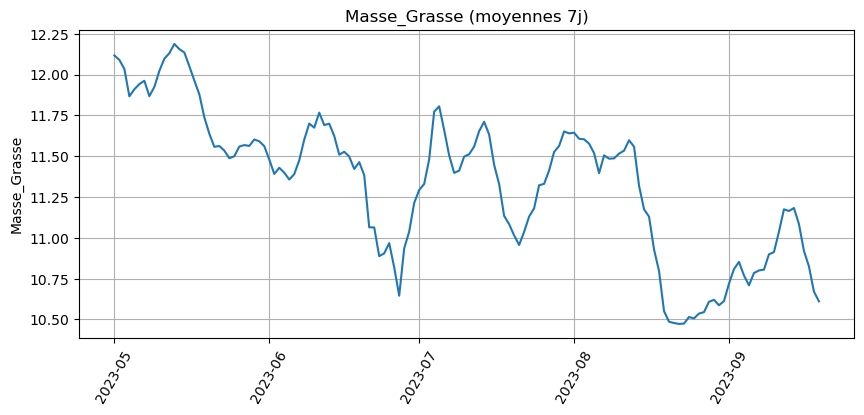

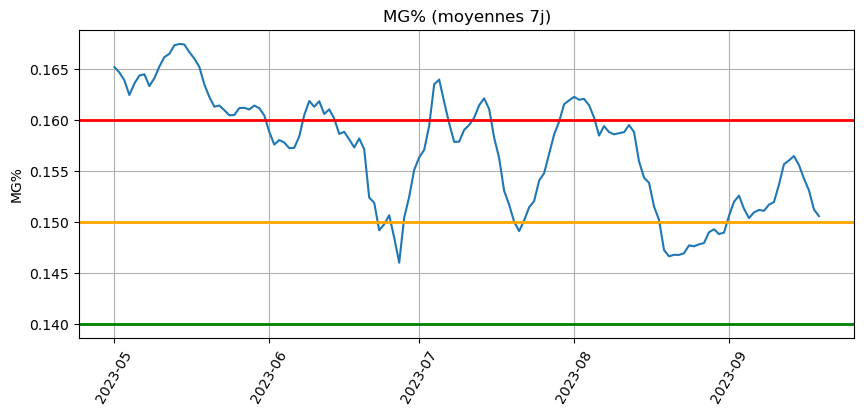

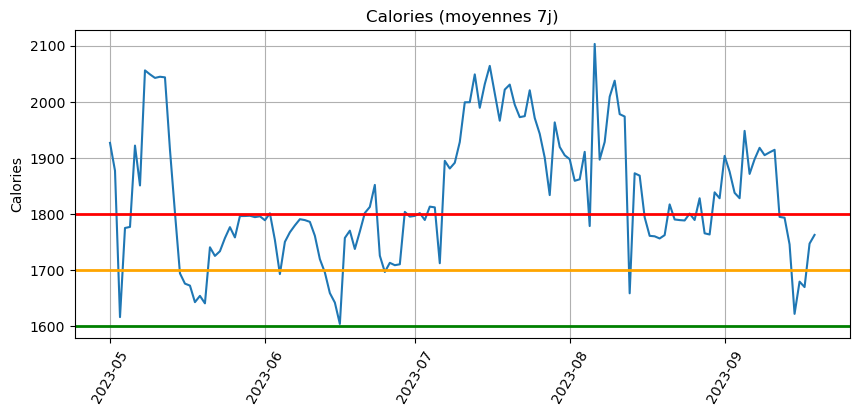

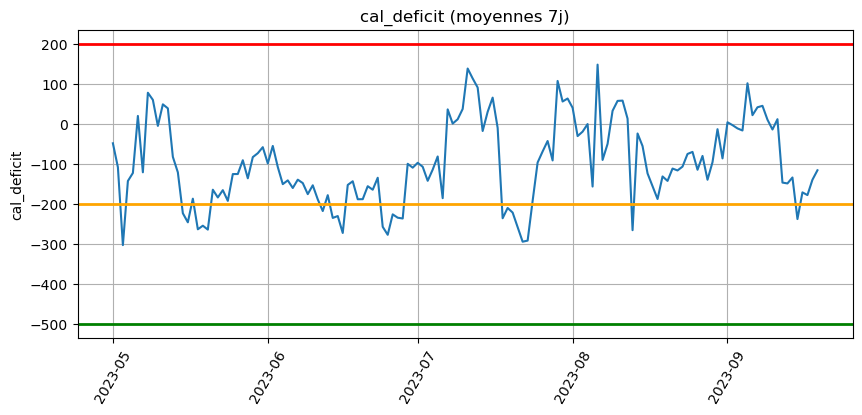

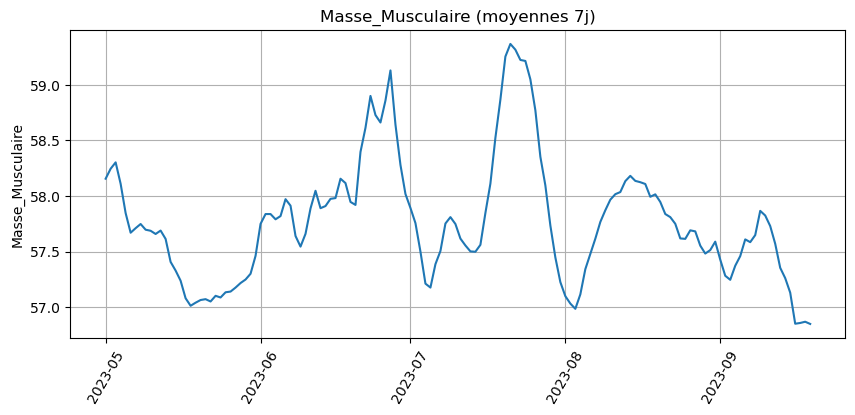

In [32]:
plot_general(longueur=7)

In [33]:
vars = ['Masse_Grasse', 'MG%', 'Calories', 'cal_deficit', 'Masse_Musculaire'] # 'Masse_Grasse', 'BMR', 'Masse_Totale', 'exo_cals_nets', 'Masse_Musculaire', 

ipywidgets.interact(plot_general, longueur=(1,90,7), year=(2020,2023,1), month=(1,12,1))

interactive(children=(IntSlider(value=15, description='longueur', max=90, min=1, step=7), IntSlider(value=2023…

<function __main__.plot_general(longueur=15, year=2023, month=5, day=1)>

In [34]:
def plot_general2(longueur=15,
                 year=2023,
                 month=5,
                 day=1,
):
    # vars = ['Masse_Totale', 'MG%', 'BMR', 'Calories', 'cal_deficit']
    
    subset = ['Masse_Totale', 'Masse_Grasse'] # on permet des NaN en masse osseuse, etc en attendant d'avoir des data
    df_all2 = df_all.rolling(longueur).mean().dropna(subset = subset)
    start_date = datetime.date(year=year, month=month, day=day)

    df_all2 = df_all2[df_all2.index >= start_date]

    fig, ax = plt.subplots(figsize=(12,5))
    
    x = df_all2.index
    y1 = df_all2['MG%']
    ax.plot(y1, marker='.', color='red', label='MG%')
    ax.set_ylabel('MG%')
    ax.set_ylim(bottom=0.14, top=0.17)
    ax.tick_params(axis='x', labelrotation=60)
    ax.legend()
    ax.grid()
    
    y2 = df_all2['cal_deficit']
    ax2 = ax.twinx()
    ax2.plot(y2, marker='.', color='blue', label='cal_deficit')
    ax2.set_ylabel('cal_deficit')
    ax2.set_ylim(bottom=-400.0, top=500.0)
    # ax2.legend()

In [35]:
ipywidgets.interact(plot_general2, longueur=(1,90,7), year=(2020,2023,1), month=(1,12,1), day=(1))

interactive(children=(IntSlider(value=15, description='longueur', max=90, min=1, step=7), IntSlider(value=2023…

<function __main__.plot_general2(longueur=15, year=2023, month=5, day=1)>

In [36]:
def plot_general3(longueur=15,
                 year=2023,
                 month=5,
                 day=1
):
    # vars = ['Masse_Totale', 'MG%', 'BMR', 'Calories', 'cal_deficit']
    
    subset = ['Masse_Totale', 'Masse_Grasse'] # on permet des NaN en masse osseuse, etc en attendant d'avoir des data
    df_all2 = df_all.rolling(longueur).mean().dropna(subset = subset)
    start_date = datetime.date(year=year, month=month, day=day)

    df_all2 = df_all2[df_all2.index >= start_date]

    fig, ax = plt.subplots(figsize=(12,5))
    
    x = df_all2.index
    y1 = df_all2['MG%']
    ax.plot(y1, marker='.', color='red', label='MG%')
    ax.set_ylabel('MG%')
    ax.set_ylim(bottom=0.14, top=0.17)
    ax.tick_params(axis='x', labelrotation=60)
    ax.legend()
    ax.grid()
    
    y2 = df_all2['Calories']
    ax2 = ax.twinx()
    ax2.plot(y2, marker='.', color='blue', label='cal_deficit')
    ax2.set_ylabel('Calories')
    ax2.set_ylim(bottom=1500.0, top=2500.0)
    # ax2.legend()

In [37]:
ipywidgets.interact(plot_general3, longueur=(1,90,7), year=(2020,2023,1), month=(1,12,1), day=(1))

interactive(children=(IntSlider(value=15, description='longueur', max=90, min=1, step=7), IntSlider(value=2023…

<function __main__.plot_general3(longueur=15, year=2023, month=5, day=1)>

In [38]:
def scatter_plot(mass_interval=2.0, length=15):
    """Utility plot to scatter mass_delta over LENGTH vs average cal_deficit over LENGTH"""
    
    MASS_INTERVAL = mass_interval
    LENGTH = int(length)

    current_mass = df_all['Masse_Totale'].iloc[-1]

    df_corr = df_all[(df_all['Masse_Totale'] - current_mass) <= MASS_INTERVAL]
    df_corr = df_corr.drop(columns=['Masse_Osseuse', 'Masse_Musculaire', 'Masse_Hydrique']).copy()
    
    df_corr = df_corr.rolling(window=LENGTH).mean().dropna().copy()

    df_corr['Delta_Masse_Totale'] = (df_corr['Masse_Totale'] - df_corr['Masse_Totale'].shift(periods=LENGTH))/LENGTH*7

    df_corr.dropna(inplace=True)
    
    fig, ax = plt.subplots() #figsize=(8,8))
    cal = df_corr['cal_deficit'].to_numpy()
    delta = df_corr['Delta_Masse_Totale'].to_numpy()
    
    # print(delta)
    
    ax.scatter(x=cal, y=delta)
    ax.set_xlabel(f'average calorie deficit over {LENGTH} days')
    ax.set_ylabel(f'average weekly weight change (g) over {LENGTH} days')
    ax.grid()
    
    lr = LinearRegression()
    lr.fit(cal.reshape(-1,1), delta)
    x_cal = np.linspace(start=-500, stop=500, num=100)
    y_pred = lr.predict(x_cal.reshape(-1,1))
    
    ax.scatter(x_cal, y_pred, color='red', marker='.')
    

In [39]:
ipywidgets.interact(scatter_plot, mass_interval=(1.0, 10.0, 0.5), length=(1, 30, 7))

interactive(children=(FloatSlider(value=2.0, description='mass_interval', max=10.0, min=1.0, step=0.5), IntSli…

<function __main__.scatter_plot(mass_interval=2.0, length=15)>

In [40]:
def scatter_plot2(mass_interval=2.0, length=15):
    """Utility plot to scatter mass_delta over LENGTH vs average cal_deficit over LENGTH"""
    
    MASS_INTERVAL = mass_interval
    LENGTH = int(length)

    current_mass = df_all['Masse_Totale'].iloc[-1]

    df_corr = df_all[(df_all['Masse_Totale'] - current_mass) <= MASS_INTERVAL]
    df_corr = df_corr.drop(columns=['Masse_Osseuse', 'Masse_Musculaire', 'Masse_Hydrique']).copy()
    
    df_corr = df_corr.rolling(window=LENGTH).mean().dropna().copy()

    df_corr['Delta_Masse_Totale'] = (df_corr['Masse_Totale'] - df_corr['Masse_Totale'].shift(periods=LENGTH))/LENGTH*7

    df_corr.dropna(inplace=True)
    
    fig, ax = plt.subplots() #figsize=(8,8))
    cal = df_corr['Calories'].to_numpy()
    delta = df_corr['Delta_Masse_Totale'].to_numpy()
    
    ax.scatter(x=cal, y=delta)
    ax.set_xlabel(f'average calorie intake over {LENGTH} days')
    ax.set_ylabel(f'average weekly weight variation (g) over {LENGTH} days')
    ax.grid()
    
    lr = LinearRegression()
    lr.fit(cal.reshape(-1,1), delta)
    x_cal = np.linspace(start=1500, stop=2500, num=100)
    y_pred = lr.predict(x_cal.reshape(-1,1))
    
    ax.scatter(x_cal, y_pred, color='red', marker='.')

In [41]:
ipywidgets.interact(scatter_plot2, mass_interval=(1.0, 10.0, 0.5), length=(1, 30, 7))

interactive(children=(FloatSlider(value=2.0, description='mass_interval', max=10.0, min=1.0, step=0.5), IntSli…

<function __main__.scatter_plot2(mass_interval=2.0, length=15)>

In [42]:
def scatter_plot3(mass_interval=2.0, length=15):
    """Utility plot to scatter mass_delta over LENGTH vs average cal_deficit over LENGTH"""
    
    MASS_INTERVAL = mass_interval
    LENGTH = int(length)

    current_mass = df_all['Masse_Totale'].iloc[-1]

    df_corr = df_all[(df_all['Masse_Totale'] - current_mass) <= MASS_INTERVAL]
    df_corr = df_corr.drop(columns=['Masse_Osseuse', 'Masse_Musculaire', 'Masse_Hydrique']).copy()
    
    df_corr = df_corr.rolling(window=LENGTH).mean().dropna().copy()

    df_corr['Delta_MG'] = (df_corr['Masse_Grasse'] - df_corr['Masse_Grasse'].shift(periods=LENGTH))/LENGTH*7

    df_corr.dropna(inplace=True)
    
    fig, ax = plt.subplots() #figsize=(8,8))
    cal = df_corr['Calories'].to_numpy()
    delta = df_corr['Delta_MG'].to_numpy()
    
    ax.scatter(x=cal, y=delta)
    ax.set_xlabel(f'average calorie intake over {LENGTH} days')
    ax.set_ylabel(f'average weekly fat mass variation over {LENGTH} days')
    ax.grid()
    
    lr = LinearRegression()
    lr.fit(cal.reshape(-1,1), delta)
    x_cal = np.linspace(start=1500, stop=2500, num=100)
    y_pred = lr.predict(x_cal.reshape(-1,1))
    
    ax.scatter(x_cal, y_pred, color='red', marker='.')

In [43]:
ipywidgets.interact(scatter_plot3, mass_interval=(1.0, 10.0, 0.5), length=(1, 30, 7))

interactive(children=(FloatSlider(value=2.0, description='mass_interval', max=10.0, min=1.0, step=0.5), IntSli…

<function __main__.scatter_plot3(mass_interval=2.0, length=15)>